In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns # For plotting confusion matrix
import math

import argparse # Import argparse

In [2]:
# --- Configuration ---
# Data Paths (MODIFY THESE)
vq_losses = []
vq_perplexities = []
tf_test_accuracies = []
tf_val_accuracies = []

EPOCHS_DATA_PATH = "C:/Users/HYUN/capstone/LBM/processed_data_ica/all_epochs_ica_std.npy"
LABELS_PATH = "C:/Users/HYUN/capstone/LBM/processed_data_ica/all_labels_ica.npy"

In [3]:
# Model Hyperparameters (Tune these!)
# VQ-VAE
VQ_EMBEDDING_DIM = 256       # Dimension of each codebook vector
VQ_NUM_EMBEDDINGS = 512     # Size of the codebook (K)
VQ_COMMITMENT_COST = 0.25   # Beta term in the VQ loss
VQ_DECAY = 0.99             # For EMA updates
PERCENT_CODEBOOK = 0.2      # percent of codebook filled to continue to next step
VQ_LR = 1e-5
VQ_EPOCHS = 100 # Adjust based on convergence

# Transformer
T_DIM = VQ_EMBEDDING_DIM    # Dimension for Transformer (usually matches VQ embedding)
T_NHEAD = 4                 # Number of attention heads
T_NUMLAYERS = 3             # Number of Transformer encoder layers
T_DIM_FEEDFORWARD = 128     # Dimension of feedforward layers in Transformer
T_DROPOUT = 0.2
T_LR = 1e-4
T_EPOCHS = 50 # Adjust based on convergence

# Training Hyperparameters
NUM_CLASSES = 3            # alert, transition, drowsy
BATCH_SIZE = 64
TEST_SPLIT_RATIO = 0.2
RANDOM_SEED = 42 # For reproducibility

In [4]:
# Paths for saving models
VQ_MODEL_SAVE_PATH = 'C:/Users/HYUN/capstone/LBM/training/vq_vae_model_v4.pth'
T_MODEL_SAVE_PATH = 'C:/Users/HYUN/capstone/LBM/training/transformer_classifier_v4.pth'

In [5]:
# --- Device Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [6]:
# --- 1. Vector Quantizer Layer ---
# Often uses Exponential Moving Average (EMA) for stable codebook updates
class VectorQuantizerEMA(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost, decay, epsilon=1e-5):
        super(VectorQuantizerEMA, self).__init__()

        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.commitment_cost = commitment_cost
        self.decay = decay
        self.epsilon = epsilon

        # Initialize the codebook embeddings
        self.embedding = nn.Embedding(self.num_embeddings, self.embedding_dim)
        self.embedding.weight.data.uniform_(-1./self.num_embeddings, 1./self.num_embeddings)

        # EMA tracking variables (not part of state_dict, managed manually)
        self.register_buffer('ema_cluster_size', torch.zeros(num_embeddings))
        self.register_buffer('ema_w', torch.zeros_like(self.embedding.weight.data)) # Use zeros_like

    def forward(self, inputs):
        # inputs: (Batch, Features, Dim) -> flatten to (Batch * Features, Dim)
        input_shape = inputs.shape
        flat_input = inputs.view(-1, self.embedding_dim)

        # Calculate distances: (N, D) vs (K, D) -> (N, K)
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True)
                     + torch.sum(self.embedding.weight**2, dim=1)
                     - 2 * torch.matmul(flat_input, self.embedding.weight.t()))

        # Find closest encodings (indices)
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self.num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1) # one-hot

        # Quantize and un-flatten
        quantized = torch.matmul(encodings, self.embedding.weight).view(input_shape)

        # EMA codebook update during training
        if self.training:
            # --- FIX: Use .detach() for tensors involved ONLY in EMA updates ---
            encodings_for_ema = encodings.detach()
            flat_input_for_ema = flat_input.detach()
            # -----------------------------------------------------------------

            self.ema_cluster_size = self.ema_cluster_size * self.decay + \
                                     (1 - self.decay) * torch.sum(encodings_for_ema, 0) # Use detached

            # Laplace smoothing to avoid zero counts
            # Accessing .data is generally okay for buffer updates if needed,
            # but let's be consistent and ensure calculations don't attach gradients.
            # Note: Using .data might become deprecated. The detach approach is safer.
            with torch.no_grad(): # Use no_grad context for safety on subsequent updates
                n = torch.sum(self.ema_cluster_size) # Sum within no_grad
                self.ema_cluster_size = (
                    (self.ema_cluster_size + self.epsilon)
                    / (n + self.num_embeddings * self.epsilon) * n)

                dw = torch.matmul(encodings_for_ema.t(), flat_input_for_ema) # Use detached
                self.ema_w = self.ema_w * self.decay + (1 - self.decay) * dw

                # Update embedding weights - Copying data is fine
                self.embedding.weight.data.copy_(self.ema_w / self.ema_cluster_size.unsqueeze(1))


        # Loss calculation - These should use the original tensors (with graph history)
        e_latent_loss = F.mse_loss(quantized.detach(), inputs) # Encoder loss
        q_latent_loss = F.mse_loss(quantized, inputs.detach()) # Codebook loss
        # Note: q_latent_loss uses inputs.detach() which might seem odd with EMA,
        # but the gradient for the codebook comes implicitly through the EMA updates,
        # not directly through this loss term's backward pass on the embedding.weight.
        # However, let's calculate total loss *before* the STE step for clarity.
        loss = q_latent_loss + self.commitment_cost * e_latent_loss

        # Straight Through Estimator
        quantized = inputs + (quantized - inputs).detach() # Keep this as is

        # Perplexity calculation - Use original encodings
        with torch.no_grad(): # Perplexity doesn't need gradients
            avg_probs = torch.mean(encodings, dim=0)
            perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

        # Reshape encoding_indices for transformer
        indices_for_transformer = encoding_indices.view(input_shape[0], -1)

        return loss, quantized, perplexity, indices_for_transformer

    # get_code_indices remains the same
    def get_code_indices(self, flat_input):
         # Simplified version for inference/encoding phase
         distances = (torch.sum(flat_input**2, dim=1, keepdim=True)
                     + torch.sum(self.embedding.weight**2, dim=1)
                     - 2 * torch.matmul(flat_input, self.embedding.weight.t()))
         encoding_indices = torch.argmin(distances, dim=1)
         return encoding_indices


In [7]:
# --- 2. VQ-VAE Model ---
class VQVAE(nn.Module):
    def __init__(self, input_channels, embedding_dim, num_embeddings, commitment_cost, decay):
        super(VQVAE, self).__init__()
        self.input_channels = input_channels # Num EEG channels

        # Example Encoder (adjust architecture based on your data timepoints)
        # Input: (Batch, Channels, Timepoints)
        self.encoder = nn.Sequential(
            nn.Conv1d(input_channels, 32, kernel_size=4, stride=2, padding=1), # Halves timepoints
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=4, stride=2, padding=1), # Halves timepoints again
            nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1), # No change
            nn.ReLU(),
            nn.Conv1d(128, embedding_dim, kernel_size=1, stride=1) # Project to embedding_dim
        )
        # Output: (Batch, embedding_dim, Timepoints / 4)

        self.vq_layer = VectorQuantizerEMA(num_embeddings, embedding_dim, commitment_cost, decay)

        # Example Decoder (mirrors encoder)
        # Input: (Batch, embedding_dim, Timepoints / 4)
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(embedding_dim, 128, kernel_size=1, stride=1),
            nn.ReLU(),
            nn.ConvTranspose1d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(64, 32, kernel_size=4, stride=2, padding=1), # Doubles timepoints
            nn.ReLU(),
            nn.ConvTranspose1d(32, input_channels, kernel_size=4, stride=2, padding=1, output_padding=1) # Doubles timepoints
        )
        # Output: (Batch, Channels, Timepoints)

    def forward(self, x):
        z = self.encoder(x)
        # Permute for VQ layer: (Batch, Dim, Features) -> (Batch, Features, Dim)
        z_permuted = z.permute(0, 2, 1).contiguous()
        vq_loss, quantized, perplexity, indices = self.vq_layer(z_permuted)
        # Permute back for decoder: (Batch, Features, Dim) -> (Batch, Dim, Features)
        quantized_permuted = quantized.permute(0, 2, 1).contiguous()
        x_recon = self.decoder(quantized_permuted)
        return vq_loss, x_recon, perplexity, indices

    # --- Methods for the second stage (encoding data for Transformer) ---
    def encode(self, x):
        """ Encodes input x to latent codes (indices). """
        z = self.encoder(x)
        z_permuted = z.permute(0, 2, 1).contiguous()
        flat_z = z_permuted.reshape(-1, VQ_EMBEDDING_DIM)
        indices = self.vq_layer.get_code_indices(flat_z)
        # Reshape indices back to sequence: (Batch, Features) where Features = Timepoints / 4
        indices_seq = indices.view(x.shape[0], -1)
        return indices_seq


In [8]:
# --- 3. Positional Encoding ---
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x shape: (seq_len, batch_size, embedding_dim)
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [9]:
# --- 4. Transformer Classifier Model ---
class EEGTransformerClassifier(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, nhead, num_layers, dim_feedforward, num_classes, dropout=0.1):
        super(EEGTransformerClassifier, self).__init__()
        self.num_classes = num_classes
        self.embedding_dim = embedding_dim

        # Embedding layer for the discrete codes from VQ-VAE
        self.code_embedding = nn.Embedding(num_embeddings, embedding_dim)

        # Positional Encoding
        self.pos_encoder = PositionalEncoding(embedding_dim, dropout)

        # Standard Transformer Encoder
        encoder_layers = nn.TransformerEncoderLayer(d_model=embedding_dim, nhead=nhead,
                                                    dim_feedforward=dim_feedforward, dropout=dropout,
                                                    batch_first=True) # Use batch_first=True
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)

        # Classification head
        self.classifier_head = nn.Linear(embedding_dim, num_classes)

        # CLS token - learnable parameter
        # Add 1 to num_embeddings for the CLS token's unique ID
        self.cls_token_id = num_embeddings # Use the next available index
        self.cls_embedding = nn.Parameter(torch.randn(1, 1, embedding_dim)) # (1, 1, Dim)

        self._init_weights()

    def _init_weights(self) -> None:
        initrange = 0.1
        self.code_embedding.weight.data.uniform_(-initrange, initrange)
        self.classifier_head.bias.data.zero_()
        self.classifier_head.weight.data.uniform_(-initrange, initrange)

    def forward(self, code_indices):
        # code_indices shape: (Batch, Sequence Length)
        batch_size = code_indices.shape[0]
        seq_len = code_indices.shape[1]

        # Add CLS token embedding at the beginning of each sequence
        cls_tokens = self.cls_embedding.expand(batch_size, -1, -1) # (Batch, 1, Dim)

        # Embed the code indices
        embedded_codes = self.code_embedding(code_indices) # (Batch, Seq Len, Dim)

        # Concatenate CLS token and embedded codes
        x = torch.cat((cls_tokens, embedded_codes), dim=1) # (Batch, 1 + Seq Len, Dim)

        # Add positional encoding - requires shape (Seq Len + 1, Batch, Dim)
        # Transpose for positional encoding, then transpose back
        x = x.transpose(0, 1) # (1 + Seq Len, Batch, Dim)
        x = self.pos_encoder(x)
        x = x.transpose(0, 1) # (Batch, 1 + Seq Len, Dim) - Ready for batch_first Transformer

        # Pass through Transformer Encoder
        transformer_output = self.transformer_encoder(x) # (Batch, 1 + Seq Len, Dim)

        # Use the output corresponding to the CLS token for classification
        cls_output = transformer_output[:, 0, :] # (Batch, Dim)

        # Final classification
        logits = self.classifier_head(cls_output) # (Batch, Num Classes)
        return logits

In [10]:
# --- 5. Dataset Class ---
class EEGDataset(Dataset):
    def __init__(self, data, labels, label_map):
        self.data = torch.tensor(data, dtype=torch.float32)
        # Map string labels to integers
        self.labels = torch.tensor([label_map[lbl] for lbl in labels], dtype=torch.long)
        self.label_map = label_map
        self.reverse_label_map = {v: k for k, v in label_map.items()}


    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

# --- Dataset Class for Transformer (takes code indices) ---
class EncodedEEGDataset(Dataset):
    def __init__(self, encoded_data_indices, labels): # labels should already be integers
        self.encoded_data = torch.tensor(encoded_data_indices, dtype=torch.long)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.encoded_data[idx], self.labels[idx]

In [11]:
# --- 6. Training and Evaluation Functions ---

def train_vqvae(model, dataloader, optimizer, epochs, device):
    model.train()
    print("--- Starting VQ-VAE Training ---")
    recon_criterion = nn.MSELoss()

    for epoch in range(epochs):
        total_vq_loss = 0.0
        total_recon_loss = 0.0
        total_perplexity = 0.0

        for batch_idx, (data, _) in enumerate(dataloader):
            data = data.to(device)
            optimizer.zero_grad()

            vq_loss, data_recon, perplexity, _ = model(data)
            recon_loss = recon_criterion(data_recon, data)
            
            RECON_WEIGHT = 0  # or 0 to disable completely
            loss = vq_loss + RECON_WEIGHT * recon_loss               

            if torch.isnan(loss):
                print(f"NaN detected in VQ-VAE loss at epoch {epoch+1}, batch {batch_idx}. Skipping.")
                continue

            loss.backward()
            optimizer.step()

            total_vq_loss += vq_loss.item()
            total_recon_loss += recon_loss.item()
            total_perplexity += perplexity.item()

            #if batch_idx % 10 == 0:
                #print(f"VQ Epoch {epoch+1}/{epochs} | Batch {batch_idx}/{len(dataloader)} | "
                #      f"Loss: {loss.item():.4f} (VQ: {vq_loss.item():.4f}, Recon: {recon_loss.item():.4f}) | "
                #      f"Perplexity: {perplexity.item():.2f}")

        avg_vq_loss = total_vq_loss / len(dataloader)
        avg_recon_loss = total_recon_loss / len(dataloader)
        avg_perplexity = total_perplexity / len(dataloader)
        print(f"VQ Epoch {epoch+1} Avg Loss: {(avg_vq_loss + avg_recon_loss):.4f} (VQ: {avg_vq_loss:.4f}, Recon: {avg_recon_loss:.4f}, Avg Perplexity: {avg_perplexity:.2f})")
        vq_losses.append(avg_vq_loss)
        vq_perplexities.append(avg_perplexity)


    print("--- VQ-VAE Training Finished ---")
    
    if (avg_perplexity < PERCENT_CODEBOOK * VQ_NUM_EMBEDDINGS):
        print(f" perplexity too low {avg_perplexity} to attempt training transformer, should be at least {int(100 * PERCENT_CODEBOOK)}% of codebook size: {VQ_NUM_EMBEDDINGS}")
        exit()


def encode_data_for_transformer(vq_model, dataloader, device):
    vq_model.eval()
    all_indices = []
    all_labels = []
    print("--- Encoding data using trained VQ-VAE ---")
    with torch.no_grad():
        for data, labels in dataloader:
            data = data.to(device)
            indices_seq = vq_model.encode(data) # Shape: (Batch, Seq Len)
            all_indices.append(indices_seq.cpu().numpy())
            all_labels.append(labels.numpy()) # Keep original labels

    all_indices = np.concatenate(all_indices, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    print(f"Encoded data shape (indices): {all_indices.shape}")
    print(f"Labels shape: {all_labels.shape}")
    return all_indices, all_labels


def train_transformer(model, train_loader, val_loader, optimizer, criterion, epochs, device, label_map):
    model.train()
    print("--- Starting Transformer Training ---")
    best_val_accuracy = 0.0

    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        train_preds = []
        train_targets = []

        for batch_idx, (codes, labels) in enumerate(train_loader):
            codes = codes.to(device)
            labels = labels.to(device) # Already integer labels
            optimizer.zero_grad()

            outputs = model(codes) # Get logits
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            train_preds.extend(preds.cpu().numpy())
            train_targets.extend(labels.cpu().numpy())

            #if batch_idx % 10 == 0:
            #    print(f"T Epoch {epoch+1}/{epochs} | Batch {batch_idx}/{len(train_loader)} | Loss: {loss.item():.4f}")

        avg_train_loss = total_loss / len(train_loader)
        train_accuracy = accuracy_score(train_targets, train_preds)

        # --- Validation Phase ---
        val_loss, val_accuracy, _, _ = evaluate_transformer(model, val_loader, criterion, device)


        tf_test_accuracies.append(train_accuracy)
        tf_val_accuracies.append(val_accuracy)
        print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.4f}, Val Loss  : {val_loss:.4f} | Val Acc  : {val_accuracy:.4f}")

        # Save model if validation accuracy improves
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            print(f"*** New best validation accuracy: {best_val_accuracy:.4f}. Saving model... ***")
            torch.save(model.state_dict(), T_MODEL_SAVE_PATH)

    print("--- Transformer Training Finished ---")


def evaluate_transformer(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for codes, labels in dataloader:
            codes = codes.to(device)
            labels = labels.to(device)

            outputs = model(codes)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(all_targets, all_preds)

    return avg_loss, accuracy, all_targets, all_preds

Arguments: Load VQ=False, Load Transformer=False
Loading preprocessed data...
Loaded epochs data shape: (26508, 30, 1001)
Loaded labels shape: (26508,)
Label Map: {'alert': 0, 'drowsy': 1, 'transition': 2}
--- Starting VQ-VAE Training ---
VQ Epoch 1 Avg Loss: 0.8181 (VQ: 0.0002, Recon: 0.8179, Avg Perplexity: 13.28)
VQ Epoch 2 Avg Loss: 0.8179 (VQ: 0.0001, Recon: 0.8178, Avg Perplexity: 10.83)
VQ Epoch 3 Avg Loss: 0.8180 (VQ: 0.0000, Recon: 0.8179, Avg Perplexity: 9.25)
VQ Epoch 4 Avg Loss: 0.8180 (VQ: 0.0000, Recon: 0.8179, Avg Perplexity: 7.36)
VQ Epoch 5 Avg Loss: 0.8179 (VQ: 0.0000, Recon: 0.8179, Avg Perplexity: 6.27)
VQ Epoch 6 Avg Loss: 0.8179 (VQ: 0.0000, Recon: 0.8179, Avg Perplexity: 6.17)
VQ Epoch 7 Avg Loss: 0.8179 (VQ: 0.0000, Recon: 0.8179, Avg Perplexity: 7.22)
VQ Epoch 8 Avg Loss: 0.8179 (VQ: 0.0000, Recon: 0.8179, Avg Perplexity: 9.32)
VQ Epoch 9 Avg Loss: 0.8179 (VQ: 0.0000, Recon: 0.8179, Avg Perplexity: 10.47)
VQ Epoch 10 Avg Loss: 0.8179 (VQ: 0.0000, Recon: 0.8179,

C:\Users\HYUN\AppData\Local\Temp\ipykernel_2216\3508680624.py:187: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  transformer_model.load_state_dict(torch.load(T_MODEL_SAVE_PA

Test Loss: 1.0675
Test Accuracy: 0.5432

Classification Report:
              precision    recall  f1-score   support

       alert       0.54      1.00      0.70      2880
      drowsy       0.00      0.00      0.00      1090
  transition       0.00      0.00      0.00      1332

    accuracy                           0.54      5302
   macro avg       0.18      0.33      0.23      5302
weighted avg       0.30      0.54      0.38      5302


Confusion Matrix:
[[2880    0    0]
 [1090    0    0]
 [1332    0    0]]


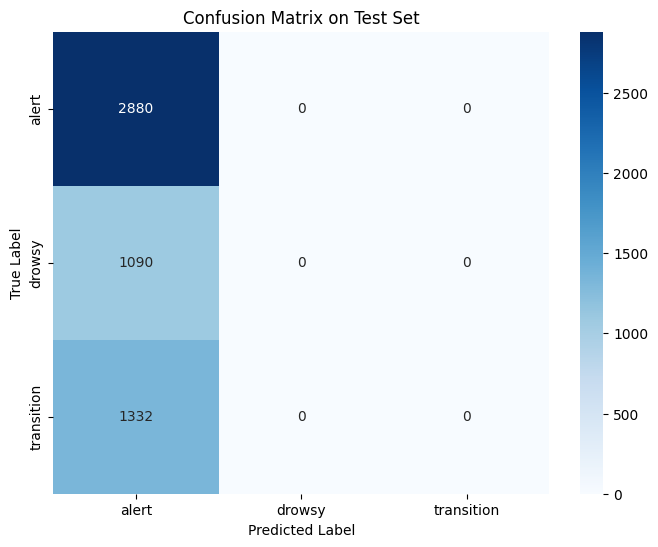

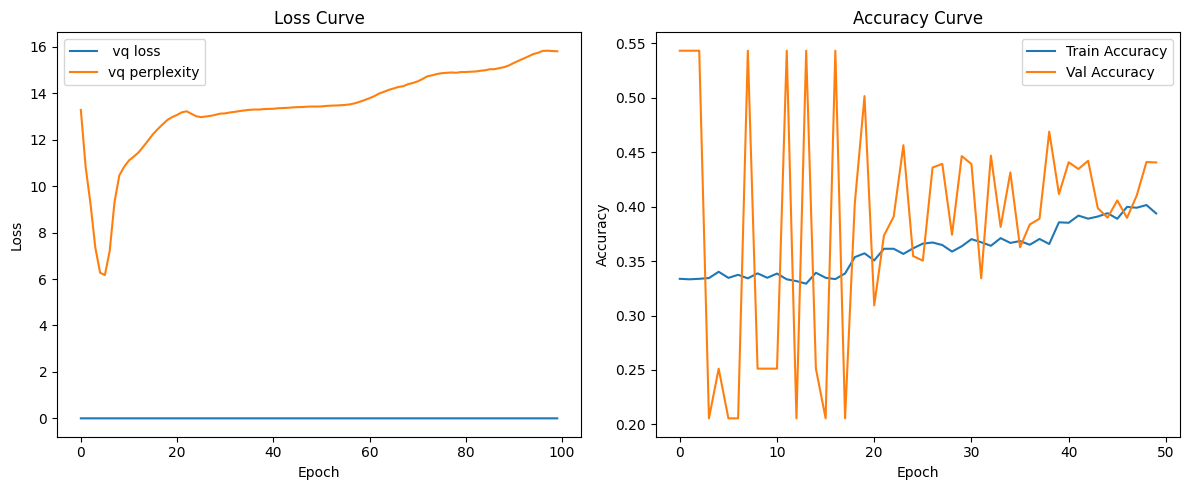


Script finished.


: 

In [ ]:
# --- 7. Main Execution ---

import sys

if __name__ == "__main__":

    # --- Argument Parsing ---
    parser = argparse.ArgumentParser(description='Train VQ-VAE and Transformer for EEG classification.')
    parser.add_argument('--load-vq', action='store_true', help='Load pre-trained VQ-VAE model instead of training.')
    parser.add_argument('--load-transformer', action='store_true', help='Load pre-trained Transformer model instead of training.')
    args = parser.parse_args(args=[]) if hasattr(sys, 'ps1') else parser.parse_args()
    # --- End Argument Parsing ---

    print(f"Arguments: Load VQ={args.load_vq}, Load Transformer={args.load_transformer}")

    # --- Load Prepared Data ---
    print("Loading preprocessed data...")
    try:
        # Ensure shapes are (num_epochs, num_channels, num_timepoints)
        epochs_data = np.load(EPOCHS_DATA_PATH)
        labels = np.load(LABELS_PATH, allow_pickle=True) # Allow pickle if labels are strings
        print(f"Loaded epochs data shape: {epochs_data.shape}")
        print(f"Loaded labels shape: {labels.shape}")
        # Example: (1000, 30, 500) -> 1000 epochs, 30 channels, 500 timepoints
        n_channels = epochs_data.shape[1]
        n_timepoints = epochs_data.shape[2]

    except FileNotFoundError:
        print(f"Error: Data files not found at {EPOCHS_DATA_PATH} or {LABELS_PATH}")
        print("Please run the previous script to generate and save these files if they do not exist.")
        exit()
    except Exception as e:
        print(f"Error loading data: {e}")
        exit()

    # --- Create Label Map ---
    unique_labels = sorted(list(set(labels)))
    if len(unique_labels) != NUM_CLASSES:
         print(f"Warning: Found {len(unique_labels)} unique labels, but expected {NUM_CLASSES}. Check labels.")
         print(f"Unique labels found: {unique_labels}")
         # Adjust NUM_CLASSES if necessary, but ensure it matches your intent
         # NUM_CLASSES = len(unique_labels)
    label_map = {label: i for i, label in enumerate(unique_labels)}
    reverse_label_map = {v: k for k, v in label_map.items()}
    print(f"Label Map: {label_map}")

    


    # --- Create Datasets and Dataloaders (for VQ-VAE training) ---
    full_dataset = EEGDataset(epochs_data, labels, label_map)
    # Note: We use the full dataset for unsupervised VQ-VAE training here.
    # A separate split could be used if desired.
    vq_dataloader = DataLoader(full_dataset, batch_size=BATCH_SIZE, shuffle=True)

    # --- Initialize and Train VQ-VAE ---
    vq_model = VQVAE(input_channels=n_channels,
                     embedding_dim=VQ_EMBEDDING_DIM,
                     num_embeddings=VQ_NUM_EMBEDDINGS,
                     commitment_cost=VQ_COMMITMENT_COST,
                     decay=VQ_DECAY).to(device)

    vq_optimizer = optim.AdamW(vq_model.parameters(), lr=VQ_LR)

    if args.load_vq:
        if os.path.exists(VQ_MODEL_SAVE_PATH):
            print(f"Loading pre-trained VQ-VAE model from {VQ_MODEL_SAVE_PATH} \n \n")
            try:
                vq_model.load_state_dict(torch.load(VQ_MODEL_SAVE_PATH, map_location=device))
                vq_model.eval() # Set to evaluation mode if loaded
            except Exception as e:
                print(f"Error loading VQ-VAE model: {e}. Exiting.")
                exit()
        else:
            print(f"Error: --load-vq specified, but model file not found at {VQ_MODEL_SAVE_PATH}. Exiting.")
            exit()
    else:
        # Train the VQ-VAE
        train_vqvae(vq_model, vq_dataloader, vq_optimizer, VQ_EPOCHS, device)
        # Save the trained VQ-VAE
        print(f"Saving trained VQ-VAE model to {VQ_MODEL_SAVE_PATH}")
        torch.save(vq_model.state_dict(), VQ_MODEL_SAVE_PATH)

    # --- Encode the Full Dataset using Trained VQ-VAE ---
    # Create a dataloader *without* shuffling to keep data and labels aligned
    full_dataloader_no_shuffle = DataLoader(full_dataset, batch_size=BATCH_SIZE, shuffle=False)
    encoded_indices, original_int_labels = encode_data_for_transformer(vq_model, full_dataloader_no_shuffle, device)

    # --- Prepare Data for Transformer Training (Split Encoded Data) ---
    indices_train, indices_test, labels_train, labels_test = train_test_split(
        encoded_indices,
        original_int_labels, # Use the integer labels
        test_size=TEST_SPLIT_RATIO,
        random_state=RANDOM_SEED,
        stratify=original_int_labels # Stratify to keep class distribution similar
    )

        # --- Calculate Class Weights ---
    print("\nCalculating class weights for weighted loss...")
    label_counts = np.bincount(original_int_labels ) # Count occurrences of each integer label (0, 1, 2)
    total_samples = len(original_int_labels )
    if len(label_counts) != NUM_CLASSES:
        print(f"Warning: Found {len(label_counts)} classes in data but expected {NUM_CLASSES}. Adjusting...")
        # Handle cases where a class might be missing entirely in the initial data
        full_label_counts = np.zeros(NUM_CLASSES, dtype=label_counts.dtype)
        full_label_counts[:len(label_counts)] = label_counts
        label_counts = full_label_counts

    # Calculate weights: weight = total_samples / (num_classes * count_for_that_class)
    class_weights = total_samples / (NUM_CLASSES * label_counts + 1e-9) # Add epsilon for stability if a count is 0
    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
    print(f"Class counts: {label_counts}")
    print(f"Calculated class weights: {class_weights_tensor.cpu().numpy()}")

    print(f"Encoded Train data shape: {indices_train.shape}, Labels: {labels_train.shape}")
    print(f"Encoded Test data shape: {indices_test.shape}, Labels: {labels_test.shape}")

    # Create datasets and dataloaders for the Transformer
    transformer_train_dataset = EncodedEEGDataset(indices_train, labels_train)
    transformer_test_dataset = EncodedEEGDataset(indices_test, labels_test)

    #using weighted sampling
    from torch.utils.data import WeightedRandomSampler

    print("\nConfiguring WeightedRandomSampler for balanced batches...")
    # Ensure labels_train are numpy array for bincount
    labels_train_np = np.array(labels_train)
    class_counts_train = np.bincount(labels_train_np, minlength=NUM_CLASSES)

    # Calculate weight for each sample in the training set
    sample_weights = np.array([1.0 / class_counts_train[lbl] for lbl in labels_train_np])
    sample_weights_tensor = torch.DoubleTensor(sample_weights) # Sampler needs DoubleTensor

    # Create the sampler
    train_sampler = WeightedRandomSampler(weights=sample_weights_tensor,
                                        num_samples=len(sample_weights_tensor),
                                        replacement=True) # replacement=True is common

    print(f"Training class counts: {class_counts_train}")
    print(f"Sampler created for {len(sample_weights_tensor)} train samples.")

    transformer_train_loader = DataLoader(transformer_train_dataset,
                                        batch_size=BATCH_SIZE,
                                        sampler=train_sampler)

    #transformer_train_loader = DataLoader(transformer_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    transformer_test_loader = DataLoader(transformer_test_dataset, batch_size=BATCH_SIZE, shuffle=False)


    # --- Initialize and Train Transformer ---
    # Add 1 to num_embeddings for the CLS token ID
    transformer_model = EEGTransformerClassifier(num_embeddings=VQ_NUM_EMBEDDINGS + 1,
                                                 embedding_dim=T_DIM,
                                                 nhead=T_NHEAD,
                                                 num_layers=T_NUMLAYERS,
                                                 dim_feedforward=T_DIM_FEEDFORWARD,
                                                 num_classes=NUM_CLASSES,
                                                 dropout=T_DROPOUT).to(device)

    t_optimizer = optim.AdamW(transformer_model.parameters(), lr=T_LR)
    # Use CrossEntropyLoss for multi-class classification
    t_criterion = nn.CrossEntropyLoss()
    #print("Using weighted CrossEntropyLoss for Transformer.")
    #t_criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

    if args.load_transformer:
        if os.path.exists(T_MODEL_SAVE_PATH):
            print(f"Loading pre-trained Transformer model from {T_MODEL_SAVE_PATH} \n \n ")
            try:
                transformer_model.load_state_dict(torch.load(T_MODEL_SAVE_PATH, map_location=device))
                transformer_model.eval() # Set to evaluation mode
            except Exception as e:
                print(f"Error loading Transformer model: {e}. Exiting.")
                exit()
        else:
            print(f"Error: --load-transformer specified, but model file not found at {T_MODEL_SAVE_PATH}. Exiting.")
            exit()
    else:
        print("Training Transformer model...")
        train_transformer(transformer_model, transformer_train_loader, transformer_test_loader,
                          t_optimizer, t_criterion, T_EPOCHS, device, label_map) # Pass scheduler

    # --- Final Evaluation on Test Set ---
    print("\n--- Evaluating Final Transformer Model on Test Set ---")
    # Load the best model saved during training
    try:
        transformer_model.load_state_dict(torch.load(T_MODEL_SAVE_PATH, map_location=device))
        print("Loaded best saved Transformer model state.")
    except FileNotFoundError:
        print("Warning: Best model checkpoint not found. Evaluating with the final state.")
    except Exception as e:
         print(f"Error loading model checkpoint: {e}. Evaluating with final state.")


    test_loss, test_accuracy, test_targets, test_preds = evaluate_transformer(
        transformer_model, transformer_test_loader, t_criterion, device
    )

    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

    # --- Detailed Classification Report ---
    target_names = [reverse_label_map[i] for i in range(NUM_CLASSES)]
    print("\nClassification Report:")
    print(classification_report(test_targets, test_preds, target_names=target_names, zero_division=0))

    # --- Confusion Matrix ---
    print("\nConfusion Matrix:")
    cm = confusion_matrix(test_targets, test_preds)
    print(cm)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix on Test Set')
    plt.show()


    plt.figure(figsize=(12, 5))
    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(vq_losses, label=' vq loss')
    plt.plot(vq_perplexities, label='vq perplexity')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(tf_test_accuracies, label='Train Accuracy')
    plt.plot(tf_val_accuracies, label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()

    plt.tight_layout()
    plt.show()

    print("\nScript finished.")

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, f1_score, roc_auc_score
from torch.nn.functional import softmax
from sklearn.preprocessing import label_binarize


all_preds = []
all_targets = []
all_logits = []

transformer_model.eval()
with torch.no_grad():
    for codes, labels in transformer_test_loader:
        codes = codes.to(device)
        labels = labels.to(device)

        outputs = transformer_model(codes)  # logits
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(labels.cpu().numpy())
        all_logits.extend(outputs.cpu().numpy())  # logits 


NameError: name 'transformer_model' is not defined

In [ ]:
# MSE & MAE
mse = mean_squared_error(all_targets, all_preds)
mae = mean_absolute_error(all_targets, all_preds)

# F1 Score
f1 = f1_score(all_targets, all_preds, average='weighted')  # or 'macro'

# ROC-AUC Score
y_true_bin = label_binarize(all_targets, classes=list(range(NUM_CLASSES)))
y_probs = softmax(torch.tensor(all_logits), dim=1).numpy()

roc_auc = roc_auc_score(y_true_bin, y_probs, average='weighted', multi_class='ovr')

print("\n--- Extra Evaluation Metrics ---")
print(f"MSE       : {mse:.4f}")
print(f"MAE       : {mae:.4f}")
print(f"F1-score  : {f1:.4f}")
print(f"ROC-AUC   : {roc_auc:.4f}")


In [ ]:
import matplotlib.pyplot as plt

metrics = ['MSE', 'MAE', 'F1-score', 'ROC-AUC']
scores = [mse, mae, f1, roc_auc]

plt.figure(figsize=(8, 5))
bars = plt.bar(metrics, scores)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01, f'{height:.3f}', ha='center', va='bottom')

plt.title('Evaluation Metrics for Transformer Model')
plt.ylim(0, 1.05)
plt.ylabel('Score')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
from torch.nn.functional import softmax
import matplotlib.pyplot as plt
import numpy as np

from torch.nn.functional import softmax
import numpy as np

transformer_model.eval()
test_logits = []
test_preds = []
test_targets = []

with torch.no_grad():
    for codes, labels in transformer_test_loader:
        codes = codes.to(device)
        labels = labels.to(device)

        outputs = transformer_model(codes)  # logits
        test_logits.extend(outputs.cpu().numpy())
        test_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
        test_targets.extend(labels.cpu().numpy())

test_logits = np.array(test_logits)
test_preds = np.array(test_preds)
test_targets = np.array(test_targets)


probs = softmax(torch.tensor(test_logits), dim=1).numpy()  # shape: (N, num_classes)

y_true_bin = label_binarize(test_targets, classes=list(range(NUM_CLASSES)))

# --- ROC Curve ---
plt.figure(figsize=(8, 6))
for i in range(NUM_CLASSES):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Precision-Recall Curve ---
plt.figure(figsize=(8, 6))
for i in range(NUM_CLASSES):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], probs[:, i])
    ap = average_precision_score(y_true_bin[:, i], probs[:, i])
    plt.plot(recall, precision, label=f'Class {i} (AP = {ap:.2f})')

plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# --- Evaluate Trained VQ-VAE Model on a Sample Batch ---
print("\n--- Evaluating Trained VQ-VAE Model on Sample ---")
sample_data = torch.tensor(epochs_data[:8], dtype=torch.float32).to(device)

with torch.no_grad():
    vq_loss, recon, perplexity, _ = vq_model(sample_data)
    recon_loss = F.mse_loss(recon, sample_data)
    total_loss = vq_loss + recon_loss

print(f"Reconstruction Loss (MSE): {recon_loss.item():.4f}")
print(f"VQ Loss (codebook + commitment): {vq_loss.item():.4f}")
print(f"Total Loss: {total_loss.item():.4f}")
print(f"Perplexity: {perplexity.item():.4f}")


In [ ]:
# --- Visualize VQ-VAE Evaluation Metrics on Sample ---
import matplotlib.pyplot as plt

metrics_names = ['Reconstruction Loss', 'VQ Loss', 'Total Loss', 'Perplexity']
metrics_values = [recon_loss.item(), vq_loss.item(), total_loss.item(), perplexity.item()]

plt.figure(figsize=(8, 5))
bars = plt.bar(metrics_names, metrics_values, color=['skyblue', 'orange', 'green', 'purple'])

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, f'{yval:.4f}', ha='center', va='bottom')

plt.title("VQ-VAE Evaluation on Sample Batch")
plt.ylabel("Value")
plt.ylim(0, max(metrics_values) + 0.1)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
